## Install Dependancies

In [6]:
#!pip install Arabic-Stopwords
#!pip install emoji
#!pip install Tashaphyne
#!pip install qalsadi
#!pip install np_utils

## Modules Required 

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report , roc_curve, f1_score, accuracy_score, recall_score , roc_auc_score,make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.layers import Reshape,Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM, SpatialDropout1D, Embedding
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score
import tensorflow as tf
import keras.backend as K
from keras.utils import np_utils
import re
import emoji
from nltk.corpus import stopwords
init_notebook_mode(connected=True)
from sklearn.feature_extraction.text import TfidfVectorizer
import qalsadi.lemmatizer
import nltk
nltk.download('stopwords')
import pickle

[nltk_data] Downloading package stopwords to C:\Users\abanoub
[nltk_data]     samir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataFrame = pd.read_excel("original_dataset.xlsx")

In [3]:
dataFrame

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank
...,...,...,...,...
67122,67122,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels
67123,67123,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels
67124,67124,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels
67125,67125,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels


In [4]:
dataFrame.drop(columns=['Unnamed: 0'],inplace=True)

## Clean Data

In [5]:
dataFrame.review_description.duplicated().sum()

139

In [6]:
dataFrame.drop(dataFrame[dataFrame.review_description.duplicated() == True].index, axis = 0, inplace = True)

In [7]:
dataFrame.reset_index(drop=True)

,review_description,rating,company
0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,ابلكيشن زباله بجد,-1,alahli_bank
2,سيئ التطبيق لايعمل,-1,alahli_bank
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank
...,...,...,...
66983,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels
66984,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels
66985,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels
66986,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels


In [8]:
dataFrame.review_description.duplicated().sum()

0

In [9]:
dataFrame.review_description.duplicated().isnull().sum()

0

# EDA

## Let's take a look on the ratings distribution in the data

In [10]:
fig = go.Figure(data=[go.Pie(labels=["postive","negative","neutral"],values=[dataFrame.rating[dataFrame.rating==x].count() for x in dataFrame.rating.unique()],pull=[0, 0.1, 0])])
fig.update_layout(title='Ratings')
iplot(fig)

## Conculsion
### **The major is Postive and Negative while the precentage of the neutral is small**

## What the heights company feedbacks in the data?

In [11]:
fig=go.Figure(data=[go.Pie(labels=dataFrame.company.unique(),values=dataFrame.company.value_counts(),hole=0.5)])
iplot(fig)
fig.show()

## Conculsion
### **The highest company feedback in the data is Al Ahly bank  then talbalt**

## Lets show the companies vs their feedbacks

In [12]:
dataFrame2=dataFrame.copy()
dataFrame2.rating=dataFrame.rating.map({0:"neutral",1:"postive",-1:"negative"})

In [13]:
fig=px.sunburst(dataFrame2,path=["company","rating"],title="Companies and Feedbacks", color_continuous_scale='RdBu',color="rating")
fig.update_traces(textinfo='label + percent parent')
fig.show()

## lets takes a look for every company ratings distrbutions

In [14]:
for companyName in dataFrame.company.unique():
    fig = go.Figure(data=[go.Bar(y=dataFrame.rating[dataFrame["company"]==companyName].value_counts(),x=dataFrame.rating[dataFrame["company"]==companyName].unique())])
    fig.update_layout(title=companyName+' Ratings')
    iplot(fig)

# Text Preprocessing

## Remove StopWords

In [15]:
stopWords=list(set(stopwords.words("arabic")))## To remove duplictes and return to list again 
#Some words needed to work with to will remove 
for word in ['واو','لا','لكن','ولكن','أطعم', 'أف','ليس','ولا','ما']:
    stopWords.remove(word)

In [16]:
len(stopWords)

692

### Lets see example how will apply effect the reviews

In [17]:
dataFrame.review_description

0                               سيئ جدا بعد الإصدار الجديد
1                                        ابلكيشن زباله بجد
2                                       سيئ التطبيق لايعمل
3        للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...
4                           التحديث بطيئ جدا جدا عند الفتح
                               ...                        
67122    كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...
67123    أول تجربة مع الخيال العلمي...الكثير من المعلوم...
67124    مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...
67125    الرسائل بين وائل و شوق كانت أجمل مافي الرواية....
67126    استقبال سيء جدا وعدم الاستعداد للنزلاء . لا شي...
Name: review_description, Length: 66988, dtype: object

In [18]:
" ".join([word for word in dataFrame.review_description[9].split() if word not in stopWords])

'صراحه شي موسف'

## Handle Emojies

In [19]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "😌":"حزين",
    "🌹":"وردة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🐸":"ضفدع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",   
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",  
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",    
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",    
    "🎀":    "ورده",
    "💵":  "فلوس",   
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",  
    "😬":"عدم الراحة",   
    "👊🏿":"يضرب",    
    "🌿":"ورقه شجره",     
    "✋🏼":"كف ايد",    
    "👐":"ايدي مفتوحه",      
    "☠️":"وجه مرعب",     
    "🎉":"يهنئ",      
    "🔕" :"صامت",
    "😿":"وجه حزين",      
    "☹️":"وجه يائس",     
    "😘" :"حب",     
    "😰" :"خوف و حزن",
    "🌼":"ورده",      
    "💋":  "بوسه",
    "👇":"لاسفل",     
    "❣️":"حب",     
    "🎧":"سماعات",
    "📝":"يكتب",      
    "😇":"دايخ",      
    "😈":"رعب",      
    "🏃":"يجري",      
    "✌🏻":"علامه النصر",    
    "🔫":"يضرب",      
    "❗️":"تعجب",
    "👎":"غير موافق",      
    "🔐":"قفل",      
    "👈":"لليمين",
    "™":"رمز",    
    "🚶🏽":"يتمشي",    
    "😯":"متفاجأ",  
    "✊":"يد مغلقه",    
    "😻":"اعجاب",    
    "🙉" :"قرد",    
    "👧":"طفله صغيره",     
    "🔴":"دائره حمراء",      
    "💪🏽":"قوه",     
    "💤":"ينام",     
    "👀":"ينظر",     
    "✍🏻":"يكتب",  
    "❄️":"تلج",
    "💀":"رعب",   
    "😤":"وجه عابس",      
    "🖋":"قلم",      
    "🎩":"كاب",      
    "☕️":"قهوه",     
    "😹":"ضحك",     
    "💓":"حب",      
    "☄️ ":"نار",     
    "👻":"رعب",
    "❎":"خطء",
    "🤮":"حزن",
    '🏻':"احمر"
    }

emoticons_to_emoji = {
    ":)" : "🙂",
    ":(" : "🙁",
    "xD" : "😆",
    ":=(": "😭",
    ":'(": "😢",
    ":'‑(": "😢",
    "XD" : "😂",
    ":D" : "🙂",
    "♬" : "موسيقي",
    "♡" : "❤",
    "☻"  : "🙂",
    }



In [20]:
def remove_diacritics(text):
        arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
        text = re.sub(arabic_diacritics, '', str(text))
        return text

In [21]:
def checkemojie(text):
    emojistext=[]
    for char in text:
        if any(emoji.distinct_emoji_list(char)) and char in emojis.keys():
            emojistext.append(emojis[emoji.distinct_emoji_list(char)[0]])
    return " ".join(emojistext)
def emojiTextTransform(text):
    cleantext=re.sub(r'[^\w\s]','',text)
    return cleantext+" "+checkemojie(text)

In [22]:
def data_preprocessing(tex):
  #Remove Punctuation
  dataFrame['clean_text']=tex.astype(str)
  dataFrame['clean_text']=dataFrame['clean_text'].apply(lambda x:re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', x))
  dataFrame['clean_text']=dataFrame['clean_text'].apply(lambda x:x.replace('؛',"", ))
  #remove stopwords
  dataFrame['clean_text']=dataFrame['clean_text'].apply(lambda x:" ".join([word for word in x.split() if word not in stopWords]))
  #Handle Emojies
  dataFrame['clean_text']=dataFrame['clean_text'].apply(lambda x:emojiTextTransform(x))
  #Remove diacritics
  dataFrame['clean_text']=dataFrame.clean_text.apply(remove_diacritics)
  #Remove Numbers
  dataFrame['clean_text']=dataFrame['clean_text'].apply(lambda x:''.join([word for word in x if not word.isdigit()]))

apply data preprocessing

In [ ]:
data_preprocessing(dataFrame.review_description)

In [ ]:
dataFrame

,review_description,rating,company,clean_text
0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank,سيئ جدا الإصدار الجديد
1,ابلكيشن زباله بجد,-1,alahli_bank,ابلكيشن زباله بجد
2,سيئ التطبيق لايعمل,-1,alahli_bank,سيئ التطبيق لايعمل
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank,للأسف التطبيق للأسوأ جدا رائع وسهل وبسيط معقد ...
4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank,التحديث بطيئ جدا جدا الفتح
...,...,...,...,...
67122,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels,كتاب جيد مملا الشيء منتصف الكتاب
67123,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels,تجربة الخيال العلمي الكثير المعلومات بقالب ممت...
67124,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels,مرضي الافطار لذيذ لا يوجد قائمة طعام الغرفةلم ...
67125,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels,الرسائل وائل شوق كانت أجمل مافي الرواية أنها ك...


## Data is cleaned now

In [ ]:
dataFrame.clean_text.duplicated().sum()

1256

In [ ]:
dataFrame.drop(dataFrame[dataFrame.clean_text.duplicated() == True].index, axis = 0, inplace = True)

In [ ]:
dataFrame.reset_index(drop=True)

,review_description,rating,company,clean_text
0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank,سيئ جدا الإصدار الجديد
1,ابلكيشن زباله بجد,-1,alahli_bank,ابلكيشن زباله بجد
2,سيئ التطبيق لايعمل,-1,alahli_bank,سيئ التطبيق لايعمل
3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank,للأسف التطبيق للأسوأ جدا رائع وسهل وبسيط معقد ...
4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank,التحديث بطيئ جدا جدا الفتح
...,...,...,...,...
65727,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels,كتاب جيد مملا الشيء منتصف الكتاب
65728,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels,تجربة الخيال العلمي الكثير المعلومات بقالب ممت...
65729,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels,مرضي الافطار لذيذ لا يوجد قائمة طعام الغرفةلم ...
65730,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels,الرسائل وائل شوق كانت أجمل مافي الرواية أنها ك...


#### Apply Stemmer

In [ ]:
dataFrame['final_text_stemmer']=dataFrame.clean_text.apply(lambda x : " ".join([ArabicLightStemmer().light_stem(word) for word in x.split()]))

In [ ]:
dataFrame.head()

,review_description,rating,company,clean_text,final_text_stemmer
0,حدثت التطبيق ثم حذفت التطبيق ثم حملته مره ثاني...,-1,alahli_bank,حدثت التطبيق حذفت التطبيق حملته مره ثانية توقع...,حدث تطبيق حذف تطبيق حمل مر ثان توقع مشكل عند ط...
1,سيئ جدا في هذا اليوم بالتحديد,-1,alahli_bank,سيئ جدا اليوم بالتحديد,سيئ جد يوم تحديد
2,تطبيق لا يعمل,-1,alahli_bank,تطبيق لا يعمل,طبيق لا عمل
3,سي,-1,alahli_bank,سي,سي
4,تطبيق فاشل مايفتح,-1,alahli_bank,تطبيق فاشل مايفتح,طبيق شل مايفتح


### Apply lemmatization 

In [ ]:
lemmer = qalsadi.lemmatizer.Lemmatizer()
dataFrame['final_text_lemmatizer'] = dataFrame.clean_text.apply(lambda x:lemmer.lemmatize_text(x))

In [ ]:
def convert_list_to_str(data):
    data = str(data)
    data = data.replace("'",'')
    data = data.replace(',','')
    data = data.replace('[','')
    data = data.replace(']','')
    return data

dataFrame['final_text_lemmatizer'] = dataFrame.final_text_lemmatizer.apply(convert_list_to_str)

##### we see that using lemmitizion is better than stemming.

In [61]:
dataFrame.to_excel("final_preprocessing_dataset.xlsx")

In [23]:
dataFrame=pd.read_excel("final_preprocessing-dataset.xlsx")

In [25]:
dataFrame.drop(columns=['Unnamed: 0'],inplace=True)
dataFrame

,review_description,rating,company,clean_text,final_text_lemmatizer
0,اين المحافظات ودائرى السلام,-1,swvl,اين المحافظات ودائرى السلام,وني محافظ ودائرى سلام
1,برنامج مفيد جدا,1,hilton,برنامج مفيد جدا,برنامج مفيد جدا
2,افضل موقع للبيع والشراء برنامح سهل جدا جدا انص...,1,hilton,افضل موقع للبيع والشراء برنامح سهل جدا جدا انص...,فضل موقع بيع شراء برنامح سهل جدا جدا انصاح تحم...
3,واضح انه اسطوري👍👍❤,1,hilton,واضح انه اسطوري موافق موافق حب,واضح نهو اسطوري موافق موافق حب
4,روععه,1,hilton,روععه,روععه
...,...,...,...,...,...
61744,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels,كتاب جيد مملا الشيء منتصف الكتاب,كتاب جيد ممل شيء منتصف كتاب
61745,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels,تجربة الخيال العلمي الكثير المعلومات بقالب ممت...,تجربة خيال علم كثير معلوم قالب ممتع قصة حك عبي...
61746,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels,مرضي الافطار لذيذ لا يوجد قائمة طعام الغرفةلم ...,مرض الافطار لذيذ لا أوجد قائم طعام الغرفةلم يت...
61747,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels,الرسائل وائل شوق كانت أجمل مافي الرواية أنها ك...,رسائل ألي شوق كانت جمل مافي رواية أن كانت مجرد...


In [26]:
dataFrame.final_text_lemmatizer.isnull().sum()

1

In [27]:
dataFrame.dropna(how='any',inplace=True)
dataFrame.reset_index(drop=True,inplace=True)

In [28]:
dataFrame.final_text_lemmatizer.isnull().sum()

0

In [29]:
dataFrame.final_text_lemmatizer.duplicated().sum()

0

In [30]:
dataFrame

,review_description,rating,company,clean_text,final_text_lemmatizer
0,اين المحافظات ودائرى السلام,-1,swvl,اين المحافظات ودائرى السلام,وني محافظ ودائرى سلام
1,برنامج مفيد جدا,1,hilton,برنامج مفيد جدا,برنامج مفيد جدا
2,افضل موقع للبيع والشراء برنامح سهل جدا جدا انص...,1,hilton,افضل موقع للبيع والشراء برنامح سهل جدا جدا انص...,فضل موقع بيع شراء برنامح سهل جدا جدا انصاح تحم...
3,واضح انه اسطوري👍👍❤,1,hilton,واضح انه اسطوري موافق موافق حب,واضح نهو اسطوري موافق موافق حب
4,روععه,1,hilton,روععه,روععه
...,...,...,...,...,...
61743,كتاب جيد وإن كان مملا بعض الشيء عند منتصف الكت...,0,hotels,كتاب جيد مملا الشيء منتصف الكتاب,كتاب جيد ممل شيء منتصف كتاب
61744,أول تجربة مع الخيال العلمي...الكثير من المعلوم...,0,hotels,تجربة الخيال العلمي الكثير المعلومات بقالب ممت...,تجربة خيال علم كثير معلوم قالب ممتع قصة حك عبي...
61745,مرضي. الافطار لذيذ. لا يوجد قائمة طعام في الغر...,0,hotels,مرضي الافطار لذيذ لا يوجد قائمة طعام الغرفةلم ...,مرض الافطار لذيذ لا أوجد قائم طعام الغرفةلم يت...
61746,الرسائل بين وائل و شوق كانت أجمل مافي الرواية....,0,hotels,الرسائل وائل شوق كانت أجمل مافي الرواية أنها ك...,رسائل ألي شوق كانت جمل مافي رواية أن كانت مجرد...


In [31]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features =1000)

unigramdataGet= word_vectorizer.fit_transform(dataFrame['final_text_lemmatizer'].astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out ()
X=pd.DataFrame(np.round(unigramdataGet, 1), columns=vocab)
X[X>0] = 1

In [32]:
X

,آخر,أبدأ,أبكى,أتى,أثر,أجاب,أحب,أحد,أحداث,أحلام,...,ونى,ياريت,يتم,يد,يدى,يستاهل,يقولي,يم,يوسف,يوم
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
Y=dataFrame.rating
Y

0       -1
1        1
2        1
3        1
4        1
        ..
61743    0
61744    0
61745    0
61746    0
61747    0
Name: rating, Length: 61748, dtype: int64

In [26]:
import pickle
pickle.dump(word_vectorizer, open("custom_vectorizer.pk", "wb"))

### Split train and test set

In [34]:
x_train,x_test,y_train,y_test =  train_test_split(X,Y,random_state=42,test_size=0.02,shuffle=True)

### Model Building and Evaluation

In [35]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

### RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
trained_clf_random_forest = RandomForestClassifier().fit(x_train, y_train)
get_accuracy('RandomForestClassifier',trained_clf_random_forest,x_train, y_train, x_test, y_test)


### Naive Base

Testing accuracy   : 82.42914979757086 %
MSE [TEST]          : 0.34331983805668015
Training accuracy  : 82.64670401401352 %
MSE [TRAIN]         : 0.3357956141655512
precision :  0.8242914979757086
recall    :  0.8242914979757086
f1_score  :  0.8242914979757086


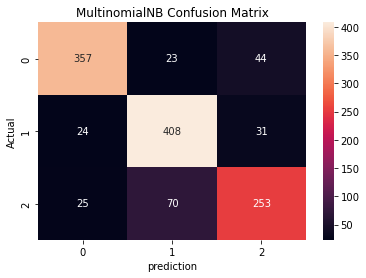

              precision    recall  f1-score   support

          -1       0.85      0.83      0.84     20390
           0       0.82      0.88      0.85     22748
           1       0.81      0.74      0.78     17375

    accuracy                           0.83     60513
   macro avg       0.83      0.82      0.82     60513
weighted avg       0.83      0.83      0.83     60513

              precision    recall  f1-score   support

          -1       0.88      0.84      0.86       424
           0       0.81      0.88      0.85       463
           1       0.77      0.73      0.75       348

    accuracy                           0.82      1235
   macro avg       0.82      0.82      0.82      1235
weighted avg       0.82      0.82      0.82      1235



In [36]:
trained_clf_multinomial_nb = MultinomialNB().fit(x_train, y_train)
get_accuracy('MultinomialNB',trained_clf_multinomial_nb,x_train, y_train, x_test, y_test)

### Linear Svc


Testing accuracy   : 86.47773279352226 %
MSE [TEST]          : 0.30526315789473685
Training accuracy  : 85.9187282071621 %
MSE [TRAIN]         : 0.3363905276552146
precision :  0.8647773279352227
recall    :  0.8647773279352227
f1_score  :  0.8647773279352227


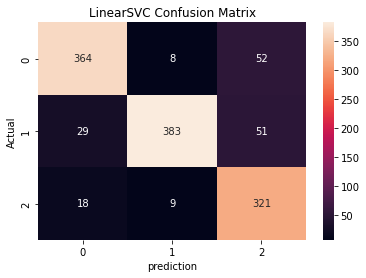

              precision    recall  f1-score   support

          -1       0.87      0.85      0.86     20390
           0       0.96      0.83      0.89     22748
           1       0.75      0.91      0.82     17375

    accuracy                           0.86     60513
   macro avg       0.86      0.86      0.86     60513
weighted avg       0.87      0.86      0.86     60513

              precision    recall  f1-score   support

          -1       0.89      0.86      0.87       424
           0       0.96      0.83      0.89       463
           1       0.76      0.92      0.83       348

    accuracy                           0.86      1235
   macro avg       0.87      0.87      0.86      1235
weighted avg       0.88      0.86      0.87      1235



In [37]:
trained_clf_svc = LinearSVC(max_iter=2000).fit(x_train, y_train)
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)

### LogisticRegression

Testing accuracy   : 86.80161943319838 %
MSE [TEST]          : 0.2874493927125506
Training accuracy  : 86.17156644026903 %
MSE [TRAIN]         : 0.3293507180275313
precision :  0.8680161943319838
recall    :  0.8680161943319838
f1_score  :  0.8680161943319838


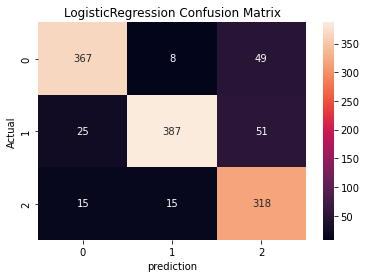

              precision    recall  f1-score   support

          -1       0.87      0.85      0.86     20390
           0       0.96      0.84      0.89     22748
           1       0.76      0.91      0.83     17375

    accuracy                           0.86     60513
   macro avg       0.86      0.86      0.86     60513
weighted avg       0.87      0.86      0.86     60513

              precision    recall  f1-score   support

          -1       0.90      0.87      0.88       424
           0       0.94      0.84      0.89       463
           1       0.76      0.91      0.83       348

    accuracy                           0.87      1235
   macro avg       0.87      0.87      0.87      1235
weighted avg       0.88      0.87      0.87      1235



In [38]:
trained_clf_LogisticRegression = LogisticRegression(max_iter=200).fit(x_train, y_train)
get_accuracy('LogisticRegression',trained_clf_LogisticRegression,x_train, y_train, x_test, y_test)

In [39]:
pickle.dump(trained_clf_LogisticRegression, open("Full_data_trained_model.sav", "wb"))

### Gradient Boost


In [ ]:
trained_clf_GradientBoost=GradientBoostingClassifier()
trained_clf_GradientBoost.fit(x_train,y_train)
get_accuracy('gboost',trained_clf_GradientBoost,x_train, y_train, x_test, y_test)

### lstm Model

In [ ]:
lstmModel = Sequential(
    [
     Embedding(1000, 100, input_length=1000),
     SpatialDropout1D(0.4),
     LSTM(50, dropout=0.3, recurrent_dropout=0.3),
     Dense(3,activation='softmax')
    ]
)
lstmModel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
lstmModel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 100)         100000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 1000, 100)        0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dense_5 (Dense)             (None, 3)                 153       
                                                                 
Total params: 130,353
Trainable params: 130,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstmModel.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=3)

Epoch 1/3
501/501 [==============================] - 1039s 2s/step - loss: 0.8262 - accuracy: 0.5970 - val_loss: 0.8333 - val_accuracy: 0.5908
Epoch 2/3
501/501 [==============================] - 1088s 2s/step - loss: 0.8197 - accuracy: 0.5990 - val_loss: 0.8329 - val_accuracy: 0.5908
Epoch 3/3
501/501 [==============================] - 1038s 2s/step - loss: 0.8194 - accuracy: 0.5990 - val_loss: 0.8340 - val_accuracy: 0.5908


### Dense Model

In [40]:
X_neuro = X
y_neuro = pd.get_dummies(Y)

In [41]:
x_train_neuro,x_test_neuro,y_train_neuro,y_test_neuro =  train_test_split(X_neuro,y_neuro,random_state=42,test_size=0.02,shuffle=True)

In [42]:
DenseModel = Sequential(
    [
     Dense(1000, activation = 'relu',input_dim=1000),
     Dense(5, activation = 'relu'),
     Dense(6, activation = 'relu'),
     Dense(3,activation='softmax')
    ]
)
DenseModel.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
DenseModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 5)                 5005      
                                                                 
 dense_2 (Dense)             (None, 6)                 36        
                                                                 
 dense_3 (Dense)             (None, 3)                 21        
                                                                 
Total params: 1,006,062
Trainable params: 1,006,062
Non-trainable params: 0
_________________________________________________________________


In [43]:
DenseModel.fit(x_train_neuro, y_train_neuro, validation_data=(x_test_neuro, y_test_neuro), batch_size=128, epochs=5)

Epoch 1/5
473/473 [==============================] - 6s 10ms/step - loss: 0.4314 - accuracy: 0.8317 - val_loss: 0.3435 - val_accuracy: 0.8761
Epoch 2/5
473/473 [==============================] - 5s 10ms/step - loss: 0.3388 - accuracy: 0.8679 - val_loss: 0.3426 - val_accuracy: 0.8704
Epoch 3/5
473/473 [==============================] - 5s 10ms/step - loss: 0.3058 - accuracy: 0.8808 - val_loss: 0.3389 - val_accuracy: 0.8721
Epoch 4/5
473/473 [==============================] - 5s 10ms/step - loss: 0.2678 - accuracy: 0.8975 - val_loss: 0.3619 - val_accuracy: 0.8704
Epoch 5/5
473/473 [==============================] - 5s 10ms/step - loss: 0.2287 - accuracy: 0.9121 - val_loss: 0.3802 - val_accuracy: 0.8680


In [44]:
DenseModel.evaluate(x_test_neuro, y_test_neuro)

39/39 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8680


[0.3802282214164734, 0.8680161833763123]

In [61]:
y_hat = DenseModel.predict(x_test_neuro)

39/39 [==============================] - 0s 4ms/step


In [62]:
def getCats(y_hat):
  cat_list = []
  for i in y_hat:
    cat_list.append(np.argmax(i) - 1)
  return np.array(cat_list)

In [63]:
y_test_new = getCats(y_hat)
y_test_new

array([-1,  0,  1, ...,  1,  1,  0], dtype=int64)

In [64]:
y_test_new.shape

(1235,)

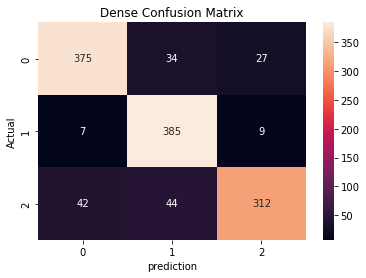

In [65]:
DenseCM = confusion_matrix(y_test_new,y_test)
sns.heatmap(DenseCM,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("Dense"+ ' Confusion Matrix')
plt.show()

In [66]:
DenseModel.save('Dense_Model.h5')